<a href="https://colab.research.google.com/github/ganeshrohan/Stock_Price_Prediction/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA



In [ ]:
# stock = pd.read_csv('https://raw.githubusercontent.com/dhiwakarK/StockPredictionWhitepaper/main/individual_stocks_5yr/individual_stocks_5yr/ACN_data.csv')
# ##('/content/ACN.csv')

In [ ]:
import yfinance as yf

# Define the stock ticker
ticker = "AAPL"

# Define the start and end dates for the data
start_date = "2010-01-01"
end_date = "2024-01-01"

# Download the data from Yahoo Finance
stock = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.333298,34049900
2023-12-29,193.899994,194.399994,191.729996,192.529999,192.284637,42628800


In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3522 non-null   float64
 1   High       3522 non-null   float64
 2   Low        3522 non-null   float64
 3   Close      3522 non-null   float64
 4   Adj Close  3522 non-null   float64
 5   Volume     3522 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.6 KB


In [ ]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,59.883701,60.528731,59.267621,59.926226,57.846540,2.422834e+08
std,55.387520,56.014467,54.812449,55.444533,55.782268,2.204578e+08
min,6.870357,7.000000,6.794643,6.858929,5.806766,2.404830e+07
25%,19.680447,19.832321,19.402321,19.608571,17.028917,9.266760e+07
50%,32.303749,32.633751,32.078751,32.340000,29.176615,1.526602e+08
75%,91.213125,92.512501,90.425623,91.207499,89.195433,3.284715e+08
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.880998e+09


In [ ]:
stock.sort_values(by='Date', ascending=True,inplace=True)

<Axes: >

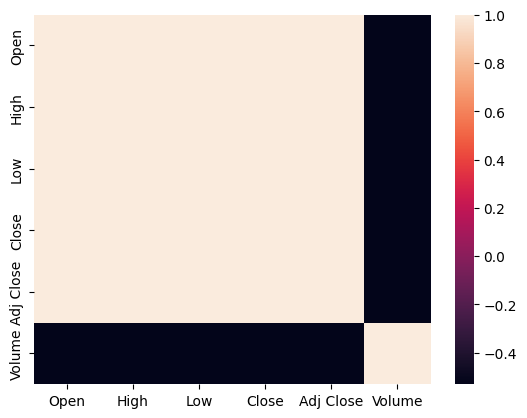

In [ ]:
sns.heatmap(stock.corr())

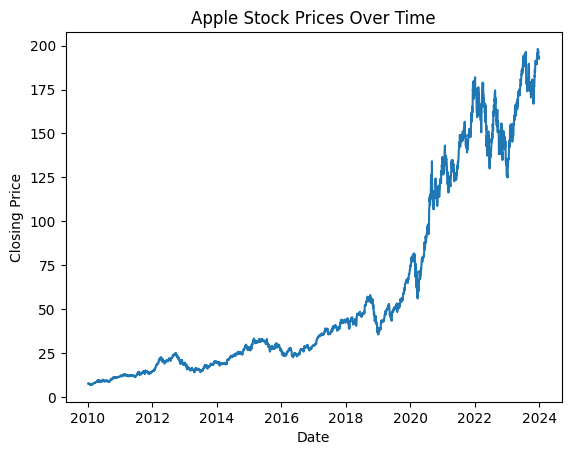

In [ ]:
# Create a line plot of stock prices over time
plt.plot(stock["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Apple Stock Prices Over Time")
plt.show()

In [ ]:
stock.drop('Volume',axis=1,inplace=True)

In [ ]:
def remove_outliers(df, min_threshold, max_threshold):
    thresholds = {}
    non_outliers_data = df.copy()  # Create a copy of the original DataFrame

    Outlier_col = non_outliers_data.select_dtypes(include='number').columns.tolist()
    # Outlier_col = Outlier_col.remove('volume')
    # print(Outlier_col)
    for column in Outlier_col:
        min_value = non_outliers_data[column].quantile(min_threshold)
        max_value = non_outliers_data[column].quantile(max_threshold)

        thresholds[column] = {'min_value': min_value, 'max_value': max_value}

        # Identify and remove outliers for the current column
        non_outliers_data = non_outliers_data[(non_outliers_data[column] > min_value) & (non_outliers_data[column] <= max_value)]

    return non_outliers_data, thresholds

In [ ]:
def create_lag_and_target(data, lag_days, target_days):
    """
    Create lagged features and target for stock price prediction."""

    # Create lagged features
    for i in range(1, lag_days + 1):
        data[f'close_{i}'] = data['Close'].shift(i)

    # Create target for the specified future day
    data['Target'] = data['Close'].shift(-target_days)

    # Drop rows with NaN values introduced by lagging
    data = data.dropna()

    return data

In [ ]:
def generate_technical_features(data):
    # Calculate additional technical indicators

    # # 1. Price Change
    # data['price_change'] = data['close_1'] - data['open']

    # # 2. High-Low Range
    # data['high_low_range'] = data['high'] - data['low']

    # # 3. Average Price
    # data['average_price'] = (data['open'] + data['high'] + data['low'] + data['close_1']) / 4

    # 4. Moving Averages (e.g., 5-day and 10-day)
    data['ma_5'] = data['close_1'].rolling(window=5, min_periods=1).mean()  # 5-day moving average
    data['ma_10'] = data['close_1'].rolling(window=10, min_periods=1).mean()  # 10-day moving average
    data['ma_21'] = data['close_1'].rolling(window=21, min_periods=1).mean()

    # 5. Price Rate of Change (ROC)
    data['roc'] = (data['close_1'] - data['close_1'].shift(1)) / data['close_1'].shift(1)

    # 6. Relative Strength Index (RSI)
    delta = data['close_1'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))

    # 7. Exponential Moving Average (EMA)
    data['ema'] = data['close_1'].ewm(span=12, min_periods=1, adjust=False).mean()
    data.fillna(method='bfill', inplace=True)
    return data

# Example usage:
# Load your stock price data into a DataFrame named 'stock_data'
# stock_data = pd.read_csv('your_stock_data.csv')
# Perform feature engineering
# engineered_data = generate_technical_features(stock_data)
# Now 'engineered_data' contains your original data with additional technical features


In [ ]:
def pca(data,component):
  # Standardize the features (important for PCA)
  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(data)

  # Initialize PCA with the desired number of components
  pca = PCA(n_components=component)

  # Fit PCA to the scaled features
  pca.fit(scaled_features)

  # Transform the original features to the PCA space
  pca_features = pca.transform(scaled_features)

  # Create a DataFrame to store the principal components
  pca_df = pd.DataFrame(data=pca_features, columns=[f'P_{i}' for i in range(1, component + 1)])

  print("Component explaining entire dataset - " + str(pca.explained_variance_ratio_))
  print("Variable extracted - " + str(pca.explained_variance_))
  return pca_df


In [ ]:
def scale_data(data, scale_type):
  scaler = MinMaxScaler()
  if scale_type == 'Reduce':
    scaled_data = scaler.fit_transform(data)
    return pd.DataFrame(scaled_data)
  else:
    reversed_data = scaler.inverse_transform(data)
    return reversed_data

In [ ]:
def model_evaluate(y_test,y_pred,model_name):
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print(f"{model_name} - Mean Squared Error: {mse}")
  print(f"{model_name} - Mean Absolute Error: {mae}")
  print(f"{model_name} - R-squared: {r2}")
  print(f"{model_name} - Mean absolute percentage error: {mape}")

In [ ]:
def show_graph(y_test,y_pred,model):
  y_pred = pd.DataFrame(y_pred)
  y_pred.index = y_test.index
  plt.plot(y_test, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title(f'{model} - Actual vs Predicted')
  plt.legend()
  plt.show()

In [ ]:
data_outlier_removed,thresholds = remove_outliers(stock,0.05,0.95)

In [ ]:
data_outlier_removed.describe()

,Open,High,Low,Close,Adj Close
count,2074.000000,2074.000000,2074.000000,2074.000000,2074.000000
mean,42.331280,42.770443,41.892174,42.344683,39.962056
std,25.991181,26.346697,25.609694,25.979485,26.177302
min,17.684999,17.911785,17.626785,17.849285,15.577768
25%,24.645447,24.886250,24.432500,24.675178,22.230267
50%,32.303749,32.633751,32.078751,32.340000,29.176615
75%,48.739376,49.255626,48.332500,48.704376,46.944079
max,128.697495,129.720001,125.940002,126.522499,124.158974


<Axes: >

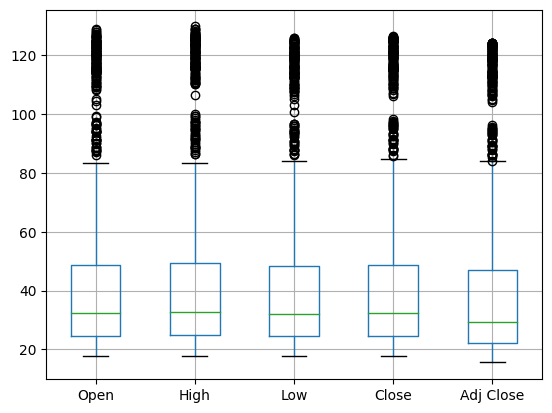

In [ ]:
data_outlier_removed.boxplot()

In [ ]:
# Assuming 'df' is your DataFrame with a 'Close' column
# and you want to create a lag of 40 days and predict the 50th day close price
data = create_lag_and_target(data_outlier_removed, lag_days=14, target_days=5)

In [ ]:
data_outlier_removed

,Open,High,Low,Close,Adj Close,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,Target
Date,,,,,,,,,,,,,,,,,,,,
2012-02-23,18.395714,18.493929,18.196428,18.442499,15.613412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.445356
2012-02-24,18.559643,18.674999,18.522858,18.657499,15.795429,18.442499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.470715
2012-02-27,18.618214,18.875000,18.438572,18.777143,15.896718,18.657499,18.442499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.041430
2012-02-28,18.855715,19.121786,18.780357,19.121786,16.188496,18.777143,18.657499,18.442499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.937857
2012-02-29,19.341429,19.557501,19.132143,19.372856,16.401045,19.121786,18.777143,18.657499,18.442499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.953215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-02,124.279999,125.239998,124.050003,125.059998,123.125214,124.279999,124.610001,125.279999,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,NaN
2021-06-03,124.680000,124.849998,123.129997,123.540001,121.628731,125.059998,124.279999,124.610001,125.279999,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,NaN
2021-06-04,124.070000,126.160004,123.849998,125.889999,123.942383,123.540001,125.059998,124.279999,124.610001,125.279999,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,NaN


In [ ]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
close_1      0
close_2      0
close_3      0
close_4      0
close_5      0
close_6      0
close_7      0
close_8      0
close_9      0
close_10     0
close_11     0
close_12     0
close_13     0
close_14     0
Target       0
dtype: int64

In [ ]:
data.reset_index(drop=True, inplace=True)

In [ ]:
# 'open','high','low','Name'
feature_columns = data.drop(['Close','Target','Open','High','Low','Adj Close'],axis=1)
print(feature_columns.columns)

Index(['close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'close_6',
       'close_7', 'close_8', 'close_9', 'close_10', 'close_11', 'close_12',
       'close_13', 'close_14'],
      dtype='object')


In [ ]:
y = data['Target']
X = data[feature_columns.columns]

In [ ]:
X.isnull().sum()

close_1     0
close_2     0
close_3     0
close_4     0
close_5     0
close_6     0
close_7     0
close_8     0
close_9     0
close_10    0
close_11    0
close_12    0
close_13    0
close_14    0
dtype: int64

In [ ]:
y.isnull().sum()

0

In [ ]:
split_index = int(len(X) * 0.8)

# Split the data
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1644, 14)
X_test shape: (411, 14)
y_train shape: (1644,)
y_test shape: (411,)


<Axes: >

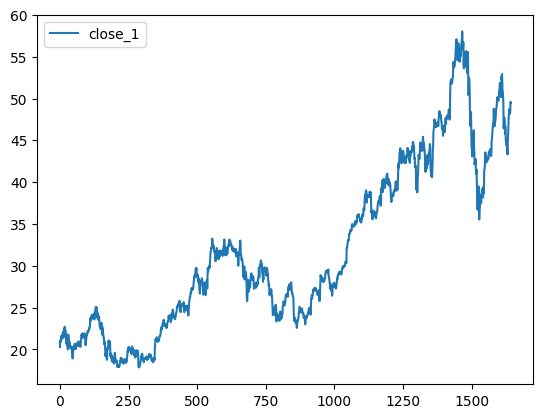

In [ ]:
X_train[['close_1']].plot()

In [ ]:
X_test

,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14
1644,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000,43.325001
1645,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000
1646,49.645000,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998
1647,48.892502,49.645000,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000
1648,49.950001,48.892502,49.645000,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999,120.589996,120.089996,122.540001
2051,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999,120.589996,120.089996
2052,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999,120.589996
2053,125.279999,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999


In [ ]:
# X_train = generate_technical_features(X_train)  # Assuming daily data with weekly seasonality

In [ ]:
X_train

,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14
0,20.289286,19.714287,19.470358,19.356787,18.953215,18.937857,19.041430,19.470715,19.445356,19.372856,19.121786,18.777143,18.657499,18.442499
1,21.056429,20.289286,19.714287,19.470358,19.356787,18.953215,18.937857,19.041430,19.470715,19.445356,19.372856,19.121786,18.777143,18.657499
2,20.912857,21.056429,20.289286,19.714287,19.470358,19.356787,18.953215,18.937857,19.041430,19.470715,19.445356,19.372856,19.121786,18.777143
3,20.913214,20.912857,21.056429,20.289286,19.714287,19.470358,19.356787,18.953215,18.937857,19.041430,19.470715,19.445356,19.372856,19.121786
4,21.467857,20.913214,20.912857,21.056429,20.289286,19.714287,19.470358,19.356787,18.953215,18.937857,19.041430,19.470715,19.445356,19.372856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000,43.325001,43.767502,44.575001,44.345001,44.557499,44.742500
1640,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000,43.325001,43.767502,44.575001,44.345001,44.557499
1641,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000,43.325001,43.767502,44.575001,44.345001
1642,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000,43.325001,43.767502,44.575001


In [ ]:
# X_test = generate_technical_features(X_test)

In [ ]:
#X_train = pca(X_train,4)

In [ ]:
#X_test = pca(X_test,4)

In [ ]:
X_train.isna().sum()

close_1     0
close_2     0
close_3     0
close_4     0
close_5     0
close_6     0
close_7     0
close_8     0
close_9     0
close_10    0
close_11    0
close_12    0
close_13    0
close_14    0
dtype: int64

# Linear Regression

In [ ]:
linear_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('linear_reg', LinearRegression())
])

# Fit the pipeline on the training data
linear_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('MinMax', MinMaxScaler()),
                ('linear_reg', LinearRegression())])

In [ ]:
X_test

,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14
1644,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000,43.325001
1645,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998,44.910000
1646,49.645000,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000,45.634998
1647,48.892502,49.645000,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498,46.305000
1648,49.950001,48.892502,49.645000,49.695000,49.865002,49.467499,49.612499,48.472500,48.185001,48.537498,48.547501,48.702499,48.145000,47.537498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999,120.589996,120.089996,122.540001
2051,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999,120.589996,120.089996
2052,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999,120.589996
2053,125.279999,125.430000,124.690002,124.849998,124.970001,122.769997,125.910004,126.209999,125.900002,123.000000,122.150002,119.900002,121.389999,121.209999


In [ ]:
# Make predictions on the test set
y_pred = linear_reg_pipeline.predict(X_test)

In [ ]:
linear_reg_pipeline.score(X_test,y_test)

0.9704575060516171

In [ ]:
model_evaluate(y_test,y_pred,'Linear Regression')

Linear Regression - Mean Squared Error: 19.98321835000801
Linear Regression - Mean Absolute Error: 3.1680840975000026
Linear Regression - R-squared: 0.9704575060516171
Linear Regression - Mean absolute percentage error: 0.0366333200490814


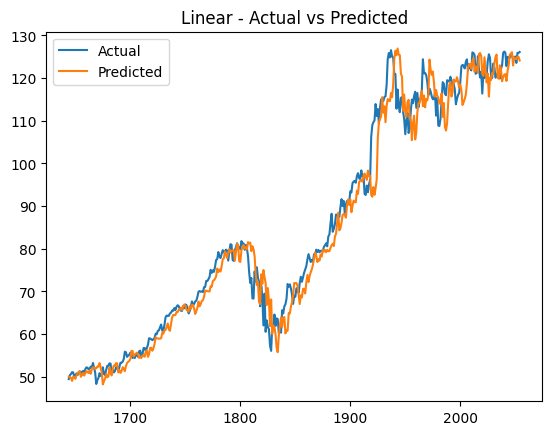

In [ ]:
show_graph(y_test,y_pred,'Linear')

In [ ]:
y_train

0       21.535713
1       20.856428
2       20.790358
3       20.927856
4       20.779285
          ...    
1618    49.480000
1619    50.387501
1620    50.682499
1621    51.102501
1622    51.057499
Name: Target, Length: 1623, dtype: float64

In [ ]:
print(linear_reg_pipeline.named_steps['linear_reg'].intercept_)
print(linear_reg_pipeline.named_steps['linear_reg'].coef_)

18.018649139910607
[40.86788608  2.2345278  -0.84636714  1.70562926  0.10616342 -1.26614324
  0.50139217 -4.08452445  3.43512084 -2.75377549 -1.21137951  2.91854902
  0.23921359 -1.89734783]


[*********************100%%**********************]  1 of 1 completed


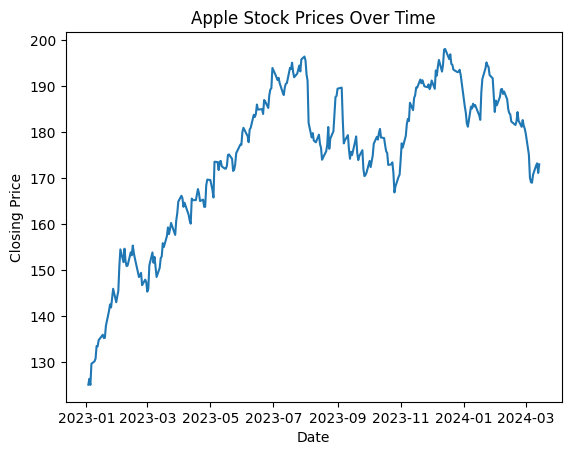

Index(['close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'close_6',
       'close_7', 'close_8', 'close_9', 'close_10', 'close_11', 'close_12',
       'close_13', 'close_14'],
      dtype='object')


In [ ]:
## Real test
# Define the stock ticker
ticker = "AAPL"

# Define the start and end dates for the data
start_date = "2023-01-02"
end_date = "2024-03-15"

# Download the data from Yahoo Finance
test_stock = yf.download(ticker, start=start_date, end=end_date)

# Create a line plot of stock prices over time
plt.plot(test_stock["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Apple Stock Prices Over Time")
plt.show()

data_test = create_lag_and_target(test_stock, lag_days=14, target_days=5)
data_test.reset_index(drop=True, inplace=True)
feature_columns_test = data_test.drop(['Close','Target','Open','High','Low','Adj Close','Volume'],axis=1)
print(feature_columns_test.columns)

y_real_test = data_test['Target']
X_Real_test = data_test[feature_columns_test.columns]

In [ ]:
y_pred_T = linear_reg_pipeline.predict(X_Real_test)
linear_reg_pipeline.score(X_Real_test,y_real_test)

0.8046059447764007

In [ ]:
model_evaluate(y_real_test,y_pred_T,'Linear Regression')

Linear Regression - Mean Squared Error: 34.988274051740675
Linear Regression - Mean Absolute Error: 4.696167552864603
Linear Regression - R-squared: 0.8046059447764007
Linear Regression - Mean absolute percentage error: 0.026590321451506107


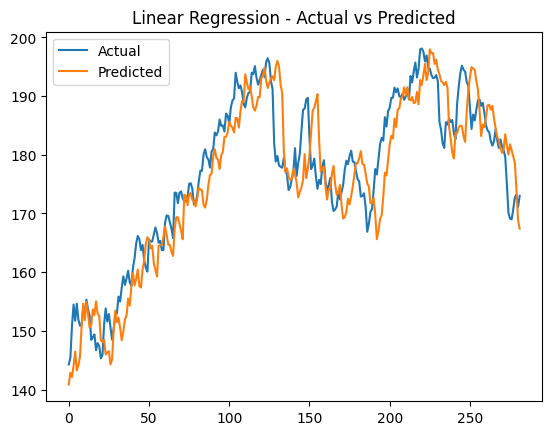

In [ ]:
show_graph(y_real_test,y_pred_T,'Linear Regression')

In [ ]:
X_Real_test['Target'] = y_real_test
X_Real_test['Predicted'] = y_pred_T
X_Real_test

<ipython-input-1240-b6d12b7d4a1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Real_test['Target'] = y_real_test
<ipython-input-1240-b6d12b7d4a1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_Real_test['Predicted'] = y_pred_T


,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,close_11,close_12,close_13,close_14,Target,Predicted
0,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993,181.910004,184.250000,185.639999,188.039993,193.175004
1,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993,181.910004,184.250000,184.399994,194.927978
2,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993,181.910004,186.860001,194.680548
3,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993,185.850006,194.487660
4,192.419998,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,187.679993,192.509133
5,191.729996,192.419998,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,189.300003,191.097642
6,188.039993,191.729996,192.419998,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,189.410004,187.630361
7,184.399994,188.039993,191.729996,192.419998,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,188.320007,183.196882
8,186.860001,184.399994,188.039993,191.729996,192.419998,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,188.850006,185.132514
9,185.850006,186.860001,184.399994,188.039993,191.729996,192.419998,194.169998,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,187.149994,184.677199


# Polynomial regression

In [ ]:
time_split = TimeSeriesSplit(n_splits=3)

In [ ]:
# Create a pipeline with PolynomialFeatures
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('linear_reg', LinearRegression())
])

# # Specify the degrees to be searched
param_grid = {
    'poly_features__degree': [1,2,3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid,cv=time_split,scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best degree from the grid search
best_degree = grid_search.best_params_['poly_features__degree']

# Plot the data and the polynomial regression curve
y_pred = grid_search.predict(X_test)

In [ ]:
print("Best Degree " + str(best_degree))
print(-grid_search.cv_results_['mean_test_score'])

Best Degree 1
[1.76859635e+00 5.62617735e+01 6.09024021e+03]


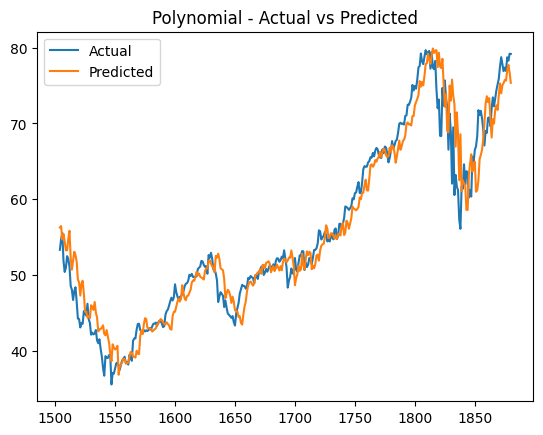

In [ ]:
show_graph(y_test,y_pred,'Polynomial')

In [ ]:
model_evaluate(y_test,y_pred,'Polynomial regression')

Polynomial regression - Mean Squared Error: 8.259162599180389
Polynomial regression - Mean Absolute Error: 2.1151812659772284
Polynomial regression - R-squared: 0.9398224853645318
Polynomial regression - Mean absolute percentage error: 0.03851030065580576


# Lasso Regression

In [ ]:
# Create a pipeline with PolynomialFeatures and Lasso Regression
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('lasso_reg', Lasso(max_iter=2000)) # max_iter=10000
])

# Specify the degrees to be searched
param_grid = {
    'poly_features__degree': [1, 2, 3],
    'lasso_reg__alpha': np.logspace(-4, 2, 7)  # Adjust the range as needed
}

# Create the GridSearchCV object
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=time_split, scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
lasso_grid_search.fit(X_train, y_train)

# Get the best degree and alpha from the grid search
best_degree = lasso_grid_search.best_params_['poly_features__degree']
best_alpha = lasso_grid_search.best_params_['lasso_reg__alpha']

print(f"Best Degree: {best_degree}")
print(f"Best Alpha: {best_alpha}")
# Print the negative of mean test scores (as GridSearchCV returns negative values)
print(-lasso_grid_search.cv_results_['mean_test_score'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.384e+01, tolerance: 1.327e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+02, tolerance: 1.734e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+02, tolerance: 2.652e

Best Degree: 1
Best Alpha: 0.0001
[  1.76653769   5.68229613 695.56115753   1.77574003   2.83463087
 158.41279054   1.98094611   2.19537197   5.89073951   5.42767448
   5.42767448   5.42767448 122.84857061 122.84857061 122.84857061
 162.72601585 162.72601585 162.72601585 162.72601585 162.72601585
 162.72601585]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+01, tolerance: 1.378e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Predict using the Lasso model
y_pred = lasso_grid_search.predict(X_test)

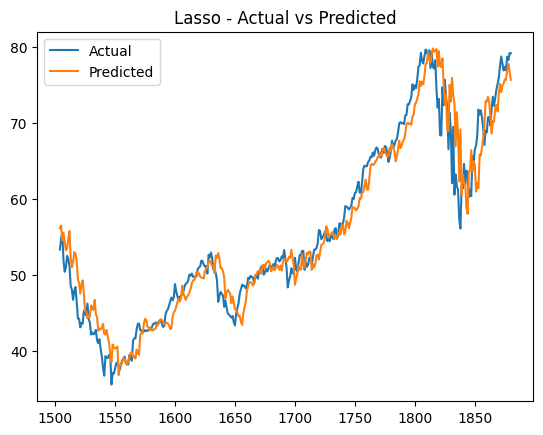

In [ ]:
show_graph(y_test,y_pred,'Lasso')

In [ ]:
model_evaluate(y_test,y_pred,'Lasso regression')

Lasso regression - Mean Squared Error: 8.321301094284719
Lasso regression - Mean Absolute Error: 2.1246181364723484
Lasso regression - R-squared: 0.939369734840049
Lasso regression - Mean absolute percentage error: 0.03871731077721835


In [ ]:
# Create a pipeline with PolynomialFeatures, MinMaxScaler, and Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('ridge_reg', Ridge(max_iter=2000))
])

# Specify the degrees and alpha to be searched
param_grid = {
    'poly_features__degree': [1, 2, 3],
    'ridge_reg__alpha': np.logspace(-4, 2, 7)  # Adjust the range as needed
}

# Create the GridSearchCV object
ridge_grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=time_split, scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
ridge_grid_search.fit(X_train, y_train)

# Get the best degree and alpha from the grid search
best_degree = ridge_grid_search.best_params_['poly_features__degree']
best_alpha = ridge_grid_search.best_params_['ridge_reg__alpha']


print(f"Best Degree - {best_degree}")
print(f"Best Alpha - {best_alpha}")

Best Degree - 1
Best Alpha - 0.0001


In [ ]:

# Plot the data and the Ridge regression curve
y_pred = ridge_grid_search.predict(X_test)

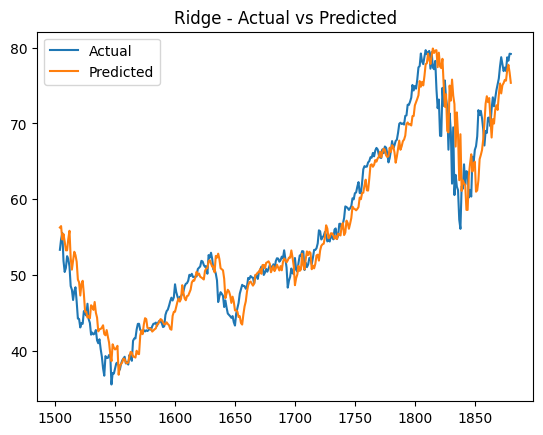

In [ ]:
show_graph(y_test,y_pred,'Ridge')

In [ ]:
model_evaluate(y_test,y_pred,'Ridge regression')

Ridge regression - Mean Squared Error: 8.258878427732453
Ridge regression - Mean Absolute Error: 2.1152038932380006
Ridge regression - R-squared: 0.9398245558809143
Ridge regression - Mean absolute percentage error: 0.03851086103636773


# Elastic Net

In [ ]:
# Create a pipeline with PolynomialFeatures, MinMaxScaler, and Elastic Net Regression
elastic_net_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('elastic_net_reg', ElasticNet())
])

# Specify the degrees and alpha to be searched
param_grid = {
    'poly_features__degree': [1, 2, 3],
    'elastic_net_reg__alpha': np.logspace(-4, 2, 7),  # Adjust the range as needed
    'elastic_net_reg__l1_ratio': [0.1, 0.5, 0.9]  # Adjust the ratios as needed
}

# Create the GridSearchCV object
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, param_grid, cv=time_split, scoring='neg_mean_squared_error', return_train_score=True)

# Perform the grid search
elastic_net_grid_search.fit(X_train, y_train)

# Get the best degree, alpha, and l1_ratio from the grid search
best_degree = elastic_net_grid_search.best_params_['poly_features__degree']
best_alpha = elastic_net_grid_search.best_params_['elastic_net_reg__alpha']
best_l1_ratio = elastic_net_grid_search.best_params_['elastic_net_reg__l1_ratio']

print(f"Best Degree - {best_degree}")
print(f"Best Alpha - {best_alpha}")
print(f"Best L1 Ratio - {best_l1_ratio}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.372e+02, tolerance: 1.734e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e+02, tolerance: 2.652e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.013e+01, tolerance: 1.327e

Best Degree - 1
Best Alpha - 0.0001
Best L1 Ratio - 0.9


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.213e+02, tolerance: 1.378e+01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
y_pred = elastic_net_grid_search.predict(X_test)

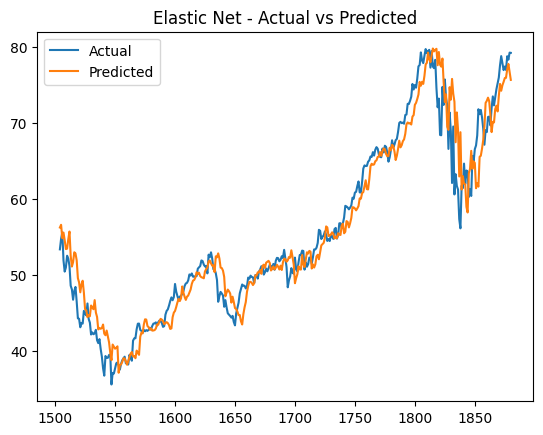

In [ ]:
show_graph(y_test,y_pred,'Elastic Net')

In [ ]:
model_evaluate(y_test,y_pred,'ElasticNet regression')

ElasticNet regression - Mean Squared Error: 8.343280287551222
ElasticNet regression - Mean Absolute Error: 2.13478481360038
ElasticNet regression - R-squared: 0.9392095910956213
ElasticNet regression - Mean absolute percentage error: 0.038918437533850575
